In [1]:


from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score, f1_score, recall_score

def input_mlflow(cv_r_v,increment_number,X_train, y_train,pipeline,run_name,experiment_id,X_test,y_test):
    

    for wi in range(len(cv_r_v)):
        
        #====================skema===================
        cols_spec = []
        data_map = {
                'int64': 'integer',
                'float64': 'double',
                'bool': 'boolean',
                'str': 'string',
                'object': 'string',
                "date": 'datetime'
            }

        for name, dtype in X_train.dtypes.to_dict().items():
            cols_spec.append(ColSpec(name=name, type=data_map[str(dtype)]))
        input_schema = Schema(inputs=cols_spec)
        output_schema = Schema([ColSpec(name="label", type="string")])
        #parameter = ParamSpec(name="model_name", dtype="string", default="model1")
        #param_schema = ParamSchema(params=[parameter])
        model_signature = ModelSignature(inputs=input_schema, outputs=output_schema)#, params=param_schema)
        #print("MODEL SIGNATURE")
        #print(model_signature.to_dict())

        model_signature = infer_signature(X_train, y_train)#, params={"model_name": "model1"})
        #print("MODEL SIGNATURE")
        #print(model_signature.to_dict())

        
        
        
        
        #====================buat run baru===================
        run_name_with_increment = f"{run_name}__{increment_number}"
            # Membuka run MLflow
        with mlflow.start_run(run_name=run_name_with_increment, experiment_id=experiment_id) as run:
            # Mendapatkan run_id
            run_id = mlflow.active_run().info.run_id
        
        print(f"'mlruns/{experiment_id}/{run_id}/artifacts/grid_search__{increment_number}','")
        increment_number=increment_number+1
        
        
        #====================buat parameter model dan metric===================

        # Definisikan grid parameter untuk dicari
        param_grid = cv_r_v[wi]
        
        #====================model===================

        # Inisialisasi GridSearchCV
        grid_search = GridSearchCV(pipeline, param_grid, cv=5,  scoring='accuracy')

        # Lakukan pencarian grid
        grid_search.fit(X_train, y_train)
        
            
        #====================parameter===================
        pipe=grid_search.best_estimator_
        
        
        first_step_name = list(pipe.named_steps.keys())[0:len(pipe)]
        

        for i in range(len(pipe)):
            # Mendapatkan parameter dari langkah 'sca'
            nama=first_step_name[i]
            sca_params = pipe.get_params()[nama]

                # Membuka run MLflow
            with mlflow.start_run( experiment_id=experiment_id,run_id=run_id) as run:

                # Log parameter secara otomatis menggunakan loop
                for param_name, param_value in sca_params.get_params().items():
                    param_name=nama+'__'+param_name
                    #print(param_name,param_value)
                    mlflow.log_param(param_name, param_value)
                    
                    
                #====================metric===================
                #matric
                hasil_test=grid_search.predict(X_test)
 
                
                
                
                                # Menghitung akurasi
                accuracy = accuracy_score(y_test, hasil_test)

                # Menghitung F1 score
                f1 = f1_score(y_test, hasil_test,average='macro')

                # Menghitung recall
                recall = recall_score(y_test, hasil_test,average='macro')

                
                
                                # Menghitung precision
                precision = precision_score(y_test, hasil_test,average='macro')


   
                

                # log model 
                mlflow.sklearn.log_model(sk_model=grid_search, artifact_path="grid_search__"+str(increment_number-1),signature=model_signature)

                metrics = {
                    'mean_test_score':pd.DataFrame(grid_search.cv_results_)['mean_test_score'].values[0],
                    "accuracy": accuracy,
                    "f1": f1,
                    "recall": recall,
                    "precision": precision,
         
                }

                mlflow.log_metrics(metrics)
                
                
        mlflow.end_run()
    print('selesai')

        
    return increment_number


     

def ambil_best(grid_search,n):
    cv_r=grid_search.copy()
    cv_r_v=cv_r.sort_values(by=['mean_test_score', 'std_test_score'], ascending=[False, True])
    cv_r_v=cv_r_v.head(n)['params'].values

    for wi in range(len(cv_r_v)):

        for i in list(cv_r_v[wi]):

            cv_r_v[wi][i]=[cv_r_v[wi][i]]


    return cv_r_v


In [2]:
import mlflow.sklearn
from sklearn.metrics import classification_report, confusion_matrix


def test(model_paths,X_test2,y_test):
    ii=1
    for i, model_path in enumerate(model_paths, start=1):
        print(f'\n\n================================| model {ii} |==========================================')
        
        model = mlflow.sklearn.load_model(model_path)
        y_pred = model.predict(X_test2)
        print(f"Classification Report for model {model_path[-2:]}:")
        print(classification_report(y_test, y_pred))
        print(f"Confusion Matrix for model {model_path[-2:]}:\n", confusion_matrix(y_test, y_pred), '\n\n')
        
        ii=ii+1

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score, f1_score, recall_score
# import libraries

import scipy.stats as stats




import statsmodels.api as sm




from scipy.stats import shapiro,normaltest,kstest,jarque_bera
import pingouin as pg
from pingouin import kruskal




from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import mlflow



from mlflow.models.signature import ModelSignature
from mlflow.models.signature import infer_signature
from mlflow.types.schema import Schema
from mlflow.types.schema import ParamSchema
from mlflow.types.schema import ParamSpec
from mlflow.types.schema import ColSpec
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import pandas as pd
from typing import Tuple


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score


import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector as selector

In [4]:
df = pd.read_csv("data/data_csv/data_bersih.csv")

In [5]:
df.head()

,Variance_Wavelet,Skewness_Wavelet,Curtosis_Wavelet,Class
0,3.62160,8.6661,-2.8073,0
1,4.54590,8.1674,-2.4586,0
2,3.86600,-2.6383,1.9242,0
3,3.45660,9.5228,-4.0112,0
4,0.32924,-4.4552,4.5718,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1368 entries, 0 to 1367
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Variance_Wavelet  1368 non-null   float64
 1   Skewness_Wavelet  1368 non-null   float64
 2   Curtosis_Wavelet  1368 non-null   float64
 3   Class             1368 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 42.9 KB


In [7]:
X = df.drop("Class",axis=1)
y = df["Class"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [9]:
from sklearn.feature_selection import mutual_info_classif
mutual_info=mutual_info_classif(X_train, y_train)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

Variance_Wavelet    0.384120
Skewness_Wavelet    0.228603
Curtosis_Wavelet    0.119284
dtype: float64

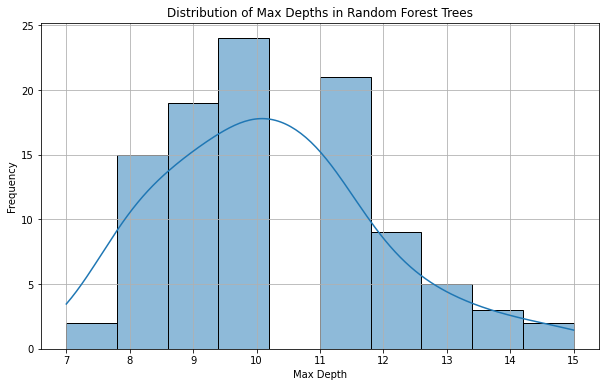

In [10]:
mod = RandomForestClassifier()
mod.fit(X_train, y_train)

# Mendapatkan kedalaman maksimum dari setiap pohon dalam hutan acak
max_depths = [estimator.tree_.max_depth for estimator in mod.estimators_]

# Membuat plot
plt.figure(figsize=(10, 6))
sns.histplot(max_depths, bins=10, kde=True)
plt.title('Distribution of Max Depths in Random Forest Trees')
plt.xlabel('Max Depth')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [11]:
n_estimators=[64,100,128,150,90,200]
bootstrap = [True,False]
oob_score = [True,False]


In [12]:
param_grid = {'rfc__n_estimators':n_estimators,
              'rfc__criterion':['gini','entropy'],
              'rfc__random_state':[11],
             'rfc__ccp_alpha': [0.0, 0.01, 0.1],
             'rfc__max_depth':np.arange(7,15),
             'rfc__bootstrap':bootstrap,
             'rfc__oob_score':oob_score} 
# Note, oob_score only makes sense when bootstrap=True!

In [13]:


numeric_features = selector(dtype_exclude="O")
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ]
)


pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('rfc', RandomForestClassifier())])


In [15]:
grid_search_rfc = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=2, error_score=np.nan)
grid_search_rfc .fit(X_train, y_train)


C:\Users\ACER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1440 fits failed out of a total of 5760.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1440 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ACER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ACER\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\ACER\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 411, in fit
    raise ValueError("Out of bag estimation only available 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000018D9B2623A0>)])),
                                       ('rfc', RandomForestClassifier())]),
             n_jobs=2,
             param_grid={'rfc__bootstrap': [True, False],
                         'rfc__ccp_alpha': [0.0, 0.01, 0.1],
                         'rfc__criterion': ['gini', 'entropy'],
                         'rfc__max_depth': array([ 7,  8,  9, 10, 11, 12, 13, 14]),
                         'rfc__n_estimators': [64, 100, 128, 150, 90, 200],
                         '

In [16]:
df_1 = pd.DataFrame(grid_search_rfc.cv_results_)
df_1.drop_duplicates(subset=['mean_test_score', 'std_test_score', 'rank_test_score'], inplace=True)
df_1 = df_1.sort_values(by=['mean_test_score', 'std_test_score'], ascending=[False, True])
df_1.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__bootstrap,param_rfc__ccp_alpha,param_rfc__criterion,param_rfc__max_depth,param_rfc__n_estimators,param_rfc__oob_score,param_rfc__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
613,0.106145,0.016369,0.006873,0.007832,False,0.0,gini,10,64,False,11,"{'rfc__bootstrap': False, 'rfc__ccp_alpha': 0....",0.995434,0.995434,0.995434,0.986301,0.986239,0.991768,0.004489,-2147483648
597,0.145163,0.025623,0.008834,0.007283,False,0.0,gini,8,90,False,11,"{'rfc__bootstrap': False, 'rfc__ccp_alpha': 0....",0.995434,0.995434,0.995434,0.990868,0.981651,0.991764,0.005357,-2147483648
697,0.128744,0.012334,0.006731,0.008289,False,0.0,entropy,9,64,False,11,"{'rfc__bootstrap': False, 'rfc__ccp_alpha': 0....",0.995434,0.995434,0.990868,0.986301,0.986239,0.990855,0.004098,-2147483648
24,0.287308,0.014292,0.015687,0.002093,True,0.0,gini,9,64,True,11,"{'rfc__bootstrap': True, 'rfc__ccp_alpha': 0.0...",0.995434,0.995434,0.995434,0.986301,0.981651,0.990851,0.005802,-2147483648
745,0.135242,0.012521,0.010659,0.007551,False,0.0,entropy,13,64,False,11,"{'rfc__bootstrap': False, 'rfc__ccp_alpha': 0....",0.990868,0.995434,0.990868,0.986301,0.986239,0.989942,0.003431,-2147483648


In [17]:
data_ambil=ambil_best(df_1.head(10),10)


In [18]:
if __name__ == "__main__":

    experiment_id = mlflow.create_experiment(
        name="project_RandomForestClassifier_new",
        tags={"env": "dev", "version": "1.0.0"},
    )

    print(experiment_id)
    

mlflow.end_run()


957117586982953484


In [19]:
run_name = "log___"
increment_number = 1

In [20]:

increment_number=input_mlflow(data_ambil,increment_number,X_train, y_train,pipeline,run_name,experiment_id,X_test,y_test)

C:\Users\ACER\anaconda3\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


'mlruns/957117586982953484/8562424f02f2452dbcbe10fe57dadc62/artifacts/grid_search__1','


C:\Users\ACER\anaconda3\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
C:\Users\ACER\anaconda3\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


'mlruns/957117586982953484/9a54d770bab8485280de254a35180842/artifacts/grid_search__2','


C:\Users\ACER\anaconda3\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


'mlruns/957117586982953484/63486fde8aa147968c2b18c0dfc832d3/artifacts/grid_search__3','


C:\Users\ACER\anaconda3\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


'mlruns/957117586982953484/7eb526d59e6343419284c2705f6f41bf/artifacts/grid_search__4','


C:\Users\ACER\anaconda3\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


'mlruns/957117586982953484/3c9a40cfe583469d8273cced67b08aa2/artifacts/grid_search__5','


C:\Users\ACER\anaconda3\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


'mlruns/957117586982953484/060ff294977c44fda342710bbb65f1a1/artifacts/grid_search__6','


C:\Users\ACER\anaconda3\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


'mlruns/957117586982953484/67f14edb38f047b59d0516cde325dbe4/artifacts/grid_search__7','


C:\Users\ACER\anaconda3\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


'mlruns/957117586982953484/7064e539473d4ddd957a60e0049a347d/artifacts/grid_search__8','


C:\Users\ACER\anaconda3\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


'mlruns/957117586982953484/70f948d1855c449d8baa61c241a90035/artifacts/grid_search__9','


C:\Users\ACER\anaconda3\lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


'mlruns/957117586982953484/d9d0e5cb54f946bd89faafa966fecc57/artifacts/grid_search__10','
selesai


In [21]:
model_paths = [
  
    'mlruns/953936056196203755/f0e26cf98911425aa95f80b64e5819d1/artifacts/grid_search__1',
    'mlruns/953936056196203755/20aa8ad4f60f4775aff2144d063c38b0/artifacts/grid_search__2',
    'mlruns/953936056196203755/229fe77d17ae4a97aa31e7f443dd960e/artifacts/grid_search__3',
    
    
    ]

test(model_paths,X_test,y_test)



================================| model 1 |==========================================


OSError: No such file or directory: 'mlruns\953936056196203755\f0e26cf98911425aa95f80b64e5819d1\artifacts\grid_search__1'